In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/FDA_approve_sm_molecules
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from FDA approved sm molecule drugs

See if they are valid or not

In [4]:
path = '/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/FDA_approve_sm_molecules/drugbank_smdrugs_inchi.txt'
small_molecule_inchi_list = []
with open(path, 'r') as f:
    for line in f:
        small_molecule_inchi_list.append(line.strip())
mol_list = [inchi.MolFromInchi(inchi_str) for inchi_str in small_molecule_inchi_list]
standardized_smiles_list = [Chem.MolToSmiles(mol) for mol in mol_list]

print(len(small_molecule_inchi_list))
len(standardized_smiles_list)

[15:47:13] Cannot assign bond directions!
[15:47:14] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match; Proton balance: Does not match)

[15:47:14] WARNING: not removing hydrogen atom without neighbors
[15:47:14] WARNING: not removing hydrogen atom without neighbors
[15:47:14] WARNING: not removing hydrogen atom without neighbors


2778


2778

Save the data to a .smi file

In [5]:
with open('drugbank_smdrugs_smiles.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [6]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...
...,...
2773,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...
2774,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...
2775,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...
2776,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C


Add an RDKit molecule to the dataframe

In [7]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

[15:47:15] WARNING: not removing hydrogen atom without neighbors
[15:47:15] WARNING: not removing hydrogen atom without neighbors
[15:47:15] WARNING: not removing hydrogen atom without neighbors


Strip salts from the molecule

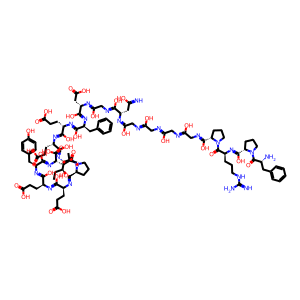

In [8]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0       [c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...
1       [C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...
2       [c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...
3       [c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...
4       [C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...
                              ...                        
2773                                                   []
2774                           [c1ccccc1, C1CNCCNCCNCCN1]
2775                        [c1ccsc1, C1=NOCC1, c1ccccc1]
2776                       [O=c1[nH]c(=O)c2[nH]cnc2[nH]1]
2777           [c1c[nH+]n[nH]1, O=C1C[C@@H]2N1CCS2(=O)=O]
Name: ring_sytems, Length: 2778, dtype: object

In [10]:
df.ring_sytems.values

array([list(['c1ccccc1', 'C1CCNC1', 'C1CCNC1', 'c1ccccc1', 'C1CCNC1', 'c1ccccc1']),
       list(['C1CCNC1', 'c1ccccc1', 'c1ccc2[nH]ccc2c1', 'c1c[nH]cn1', 'C1=NCCC1']),
       list(['c1ccccc1', 'c1ccc2[nH]ccc2c1', 'c1c[nH]cn1', 'C1=NCCC1', 'C1CCNC1']),
       ..., list(['c1ccsc1', 'C1=NOCC1', 'c1ccccc1']),
       list(['O=c1[nH]c(=O)c2[nH]cnc2[nH]1']),
       list(['c1c[nH+]n[nH]1', 'O=C1C[C@@H]2N1CCS2(=O)=O'])], dtype=object)

See how many times each ring system occurs

In [11]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
0,c1ccccc1,1722
41,C1CCOCC1,189
7,c1ccncc1,156
89,C1CCNCC1,124
44,C1CNCCN1,111
...,...,...
366,c1cc2cc(c1)Oc1ccc3c(c1)[C@H](Cc1ccc(cc1)Oc1ccc...,1
365,O=S1(=O)NCCc2ccsc21,1
363,O=C1CCS(=O)(=O)CN1,1
362,C1CCCNCCC1,1


View the ring system frequencies

In [12]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [13]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [14]:
res

0       [(c1ccccc1, 2260082), (C1CCNC1, 112428), (C1CC...
1       [(C1CCNC1, 112428), (c1ccccc1, 2260082), (c1cc...
2       [(c1ccccc1, 2260082), (c1ccc2[nH]ccc2c1, 93446...
3       [(c1ccc2[nH]ccc2c1, 93446), (c1ccc2[nH]ccc2c1,...
4       [(C1=NCC=NCC=NCC=NCC=NCCSSCC1, 0), (c1ccccc1, ...
                              ...                        
2773                                                   []
2774         [(c1ccccc1, 2260082), (C1CNCCNCCNCCN1, 313)]
2775    [(c1ccsc1, 68146), (C1=NOCC1, 2892), (c1ccccc1...
2776               [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 5703)]
2777    [(c1c[nH+]n[nH]1, 167), (O=C1C[C@@H]2N1CCS2(=O...
Name: mol, Length: 2778, dtype: object

In [15]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0
...,...,...,...,...,...
2773,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe730>,[],,-1
2774,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313
2775,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892
2776,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703


In [16]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [17]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Proton(s) added/removed

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Proton(s) added/removed

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Proton(s) added/removed

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined stereo

[15:47:20] WARNING: Omitted undefined

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...
...,...,...,...,...,...,...
2646,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe730>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10..."
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4..."
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...


How many molecules contains ring structure?

In [18]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...
...,...,...,...,...,...,...
2645,COc1ccc(F)cc1C(O)=NCc1ccc(-c2nn([C@@H](C)C(F)(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe6c0>,"[c1ccccc1, c1ccccc1, c1cn[nH]c1]",c1cn[nH]c1,85440,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(..."
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4..."
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...


In [19]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
5,CC(O)=N[C@H](Cc1ccc2ccccc2c1)C(O)=N[C@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2260>,"[c1ccc2ccccc2c1, c1ccccc1, c1ccncc1, c1ccccc1,...",c1ccc2ccccc2c1,49955,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...
...,...,...,...,...,...,...
2645,COc1ccc(F)cc1C(O)=NCc1ccc(-c2nn([C@@H](C)C(F)(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe6c0>,"[c1ccccc1, c1ccccc1, c1cn[nH]c1]",c1cn[nH]c1,85440,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(..."
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4..."
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...


### How many of them could pass PAINS filter?

Get a list of rules

In [20]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [21]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [22]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [23]:
reos.pandas_mols(df.mol)

  0%|          | 0/2651 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
2646,ok,ok
2647,ok,ok
2648,ok,ok
2649,ok,ok


In [24]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/2651 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,ok,ok
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,ok,ok
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,ok,ok
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,ok,ok
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,ok,ok
...,...,...,...,...,...,...,...,...
2646,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe730>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",ok,ok
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",ok,ok
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,ok,ok
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,ok,ok


### How many of them could pass filters suggested by Dr.Reymond?

In [25]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True
...,...,...,...,...,...,...,...
2646,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe730>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True


In [26]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True
...,...,...,...,...,...,...,...
2646,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe730>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True


### How many of them could pass RO5?

In [27]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

[15:47:40] WARNING: not removing hydrogen atom without neighbors


,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5b2d0e0>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,112428,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb20a0>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",C1=NCCC1,318,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2110>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, C1=NC...",C1=NCCC1,318,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2180>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,93446,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
4,N=C(O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb21f0>,"[C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc1, c1cccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True,False
...,...,...,...,...,...,...,...,...
2646,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe730>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True,False
2647,CC(C)(C)[Si]([18F])(c1ccc(C(=O)NC[C@@H](N=C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe7a0>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,313,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True,False
2648,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe810>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,2892,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


In [28]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
10,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2490>,[c1ccncc1],c1ccncc1,231698,InChI=1S/C8H10NO6P/c1-5-8(11)7(3-10)6(2-9-5)4-...,True,True
13,CC(=O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb25e0>,[],,-1,"InChI=1S/C3H4O3/c1-2(4)3(5)6/h1H3,(H,5,6)",True,True
14,N[C@@H](Cc1ccccc1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2650>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-...,True,True
15,O=C(O)CCCC[C@@H]1SC[C@@H]2N=C(O)N[C@@H]21,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb26c0>,[C1=N[C@H]2CSC[C@H]2N1],C1=N[C@H]2CSC[C@H]2N1,0,InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...,True,True
16,C[N+](C)(C)CCO,<rdkit.Chem.rdchem.Mol object at 0x7348a5bb2730>,[],,-1,"InChI=1S/C5H14NO/c1-6(2,3)4-5-7/h7H,4-5H2,1-3H...",True,True
...,...,...,...,...,...,...,...,...
2640,CCNCc1nc2c(O)c(Cl)cc(Cl)c2c(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe420>,[O=c1[nH]cnc2ccccc12],O=c1[nH]cnc2ccccc12,11321,InChI=1S/C12H13Cl2N3O2/c1-3-15-5-8-16-10-9(12(...,True,True
2644,[129Xe],<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe650>,[],,-1,InChI=1S/Xe/i1-2,True,True
2645,COc1ccc(F)cc1C(O)=NCc1ccc(-c2nn([C@@H](C)C(F)(...,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe6c0>,"[c1ccccc1, c1ccccc1, c1cn[nH]c1]",c1cn[nH]c1,85440,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(...",True,True
2649,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x7348a5bfe880>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


### Check the properties of generated compounds

The aim is to see if we could find specific charateristics of each algorithm

Calculate the molecular weight and then visualize the distribution:

[15:48:18] WARNING: not removing hydrogen atom without neighbors


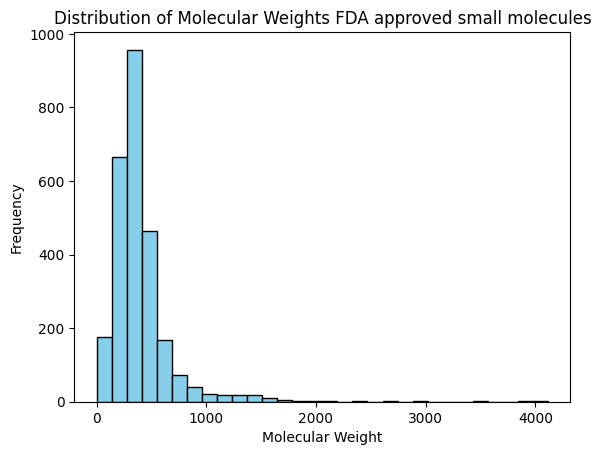

In [29]:
def calculate_molecular_weights(smiles_list):
    """Calculate molecular weights for a list of SMILES strings."""
    molecular_weights = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            molecular_weights.append(mw)
    return molecular_weights

def plot_molecular_weight_distribution(molecular_weights, bins=30):
    """Plot the distribution of molecular weights as a histogram."""
    plt.hist(molecular_weights, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Molecular Weights FDA approved small molecules")
    plt.xlabel("Molecular Weight")
    plt.ylabel("Frequency")
    plt.show()
    
molecular_weights = calculate_molecular_weights(df.SMILES.tolist())
plot_molecular_weight_distribution(molecular_weights)


Number of heavy atoms:

[15:49:30] WARNING: not removing hydrogen atom without neighbors


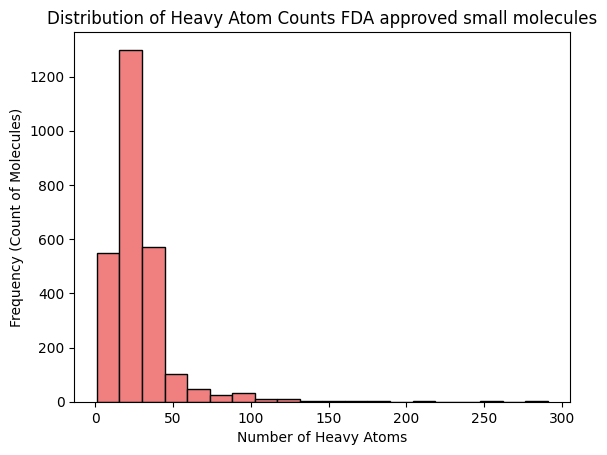

In [34]:
def calculate_heavy_atom_counts(smiles_list):
    """Calculate heavy atom counts for a list of SMILES strings."""
    heavy_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            heavy_atom_count = mol.GetNumHeavyAtoms()
            heavy_atom_counts.append(heavy_atom_count)
    return heavy_atom_counts

def plot_heavy_atom_distribution(heavy_atom_counts, bins=20):
    """Plot the distribution of heavy atom counts as a histogram with frequency on the y-axis."""
    plt.hist(heavy_atom_counts, bins=bins, color='lightcoral', edgecolor='black', density=False)
    plt.title("Distribution of Heavy Atom Counts FDA approved small molecules")
    plt.xlabel("Number of Heavy Atoms")
    plt.ylabel("Frequency (Count of Molecules)")
    plt.show()
    
heavy_atom_counts = calculate_heavy_atom_counts(df.SMILES.tolist())
plot_heavy_atom_distribution(heavy_atom_counts)

Number of hetero atoms:

[15:49:24] WARNING: not removing hydrogen atom without neighbors


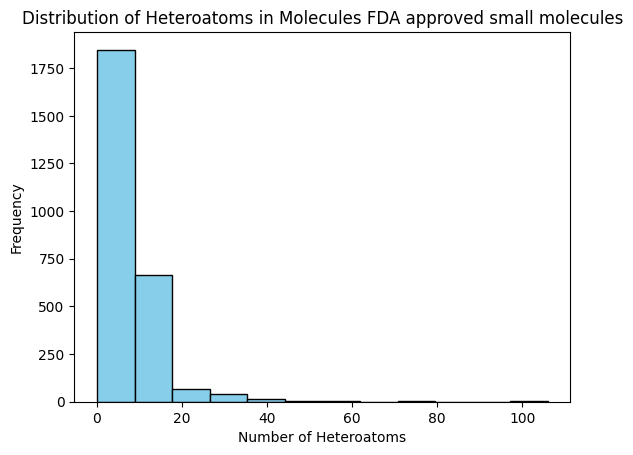

In [33]:
def calculate_heteroatom_counts(smiles_list):
    """Calculate the number of heteroatoms for each SMILES string in the list."""
    heteroatom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count atoms that are not C or H
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            heteroatom_counts.append(heteroatom_count)
    return heteroatom_counts

def plot_heteroatom_distribution(heteroatom_counts, bins=12):
    """Plot the distribution of heteroatom counts as a histogram with frequency on the y-axis."""
    plt.hist(heteroatom_counts, bins=bins, color='skyblue', edgecolor='black', density=False)
    plt.xlabel("Number of Heteroatoms")
    plt.ylabel("Frequency")
    plt.title("Distribution of Heteroatoms in Molecules FDA approved small molecules")
    plt.show()

heteroatom_counts = calculate_heteroatom_counts(df.SMILES.tolist())
plot_heteroatom_distribution(heteroatom_counts)

Ratio of hetero atoms over heavy atoms:

[15:49:17] WARNING: not removing hydrogen atom without neighbors


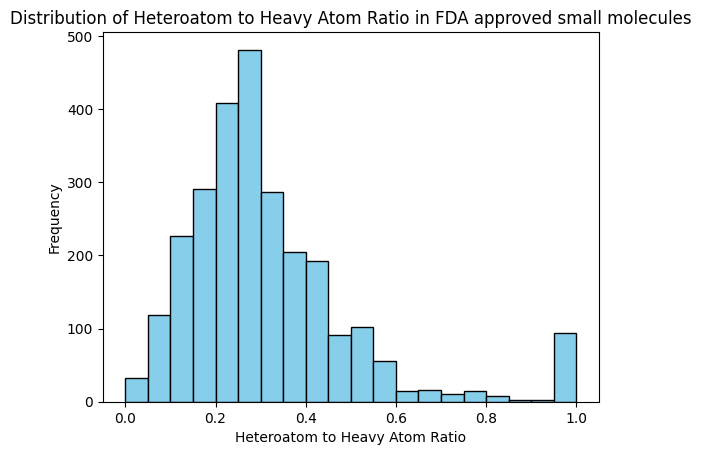

In [32]:
def calculate_heteroatom_ratio(smiles_list):
    """Calculate the ratio of heteroatoms to heavy atoms for each molecule in the SMILES list."""
    heteroatom_ratios = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count heavy atoms (all atoms except hydrogen)
            heavy_atom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1)
            # Count heteroatoms (atoms other than C and H)
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            # Calculate ratio if heavy_atom_count is non-zero
            if heavy_atom_count > 0:
                ratio = heteroatom_count / heavy_atom_count
                heteroatom_ratios.append(ratio)
    return heteroatom_ratios

def plot_heteroatom_ratio_distribution(heteroatom_ratios, bins=20):
    """Plot the distribution of heteroatom-to-heavy atom ratios as a histogram with frequency on the y-axis."""
    plt.hist(heteroatom_ratios, bins=bins, color='skyblue', edgecolor='black', density=False)
    plt.xlabel("Heteroatom to Heavy Atom Ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of Heteroatom to Heavy Atom Ratio in FDA approved small molecules")
    plt.show()
    
heteroatom_ratios = calculate_heteroatom_ratio(df.SMILES.tolist())
plot_heteroatom_ratio_distribution(heteroatom_ratios)